# Libraries

In [183]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from decimal import Decimal
import random

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [186]:
# Read data
dir = 'data_scientist_intern_revenue_model.csv'
raw_df = pd.read_csv(dir,na_values=[" -   "])
# Delete commas
raw_df.replace(',','', regex=True, inplace=True)
# To numeric
raw_df.iloc[:,1:6] = raw_df.iloc[:,1:6].apply(pd.to_numeric)
# Unify column names
raw_df.rename(columns = {'Revenue_2015 ': 'Revenue_2015'}, inplace = True)

In [120]:
df = raw_df.drop(['NAME','Revenue_2020(To predict)'], axis = 1)
# Check data
df

,Revenue_2015,Revenue_2016,Revenue_2017,Revenue_2018,Revenue_2019,Employees_2017,Employees_2018,Employees_2019,Employees_2020
0,1.903978e+10,2.467163e+10,2.457376e+10,2.260886e+10,2.657454e+10,NaN,805.0,790.0,785.0
1,3.687564e+09,3.663588e+09,3.420430e+09,3.265963e+09,3.465058e+09,NaN,2394.0,2494.0,2548.0
2,3.139300e+09,3.214000e+09,3.196900e+09,3.193700e+09,3.166000e+09,6411.0,6506.0,7750.0,NaN
3,1.994112e+09,2.023348e+09,1.982028e+09,2.007387e+09,2.009031e+09,NaN,1925.0,1995.0,2050.0
4,7.612489e+08,1.121284e+09,1.245810e+09,1.317865e+09,1.779402e+09,NaN,5159.0,5599.0,5483.0
...,...,...,...,...,...,...,...,...,...
17419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,99.0
17420,NaN,NaN,NaN,NaN,NaN,NaN,171.0,175.0,165.0
17421,7.793100e+04,5.968600e+04,2.830900e+04,1.306000e+03,NaN,NaN,NaN,NaN,12.0
17422,3.068900e+04,6.182000e+03,1.429000e+03,NaN,NaN,NaN,NaN,NaN,7.0


# Explore Data

## Check NaNs

In [46]:
print('Number of missing values per column (%)')
print(np.round(df.isnull().sum(axis = 0).sort_values(ascending = False)/len(df),2))

Number of missing values per column (%)
Employees_2017    0.87
Employees_2018    0.66
Employees_2020    0.44
Revenue_2019      0.42
Revenue_2015      0.41
Revenue_2016      0.34
Revenue_2017      0.29
Employees_2019    0.25
Revenue_2018      0.23
dtype: float64


We can see that there are two columns with a really high percentage of missing values. Since we don't have many features, we can't get rid of them.

In [35]:
print('Count rows per number of missing values')
print(df.isnull().sum(axis = 1).value_counts())

Count rows per number of missing values
3    3754
4    2585
7    2502
5    2341
1    2262
6    1966
2    1224
0     652
8     138
dtype: int64


We could consider using only complete rows or rows with a low number of missing values, but we can see that this would not be a large enough sample.

## Check Distributions

In [148]:
print('Means for each column:')
print(np.mean(df))

Means for each column:
Revenue_2015      3.234836e+07
Revenue_2016      3.143218e+07
Revenue_2017      3.201143e+07
Revenue_2018      3.330670e+07
Revenue_2019      4.220523e+07
Employees_2017    1.905321e+02
Employees_2018    3.085079e+02
Employees_2019    1.543157e+02
Employees_2020    1.871750e+02
dtype: float64


In [150]:
print('Median for each column:')
print(np.nanmedian(df, axis = 0))

Median for each column:
[1.375000e+06 1.262523e+06 1.238581e+06 1.177637e+06 1.412388e+06
 6.800000e+01 6.500000e+01 2.300000e+01 3.400000e+01]


From the means and medians we can already know that the distributions are not perfectly normal. In fact, they are right-skewed, as we can see in the figures below.

Revenues example plot


(-0.01, 0.1)

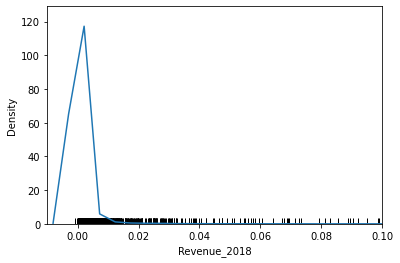

In [179]:
print('Revenues example plot')
# We scale to be able to display the plot properly
rev = df['Revenue_2018']
scale_rev = rev/rev.max()
fig, ax = plt.subplots()
sb.distplot(scale_rev, hist = False, rug = True, rug_kws={'color': 'black'}, ax=ax)
ax.set_xlim(-0.01,0.1)

Employees example plot


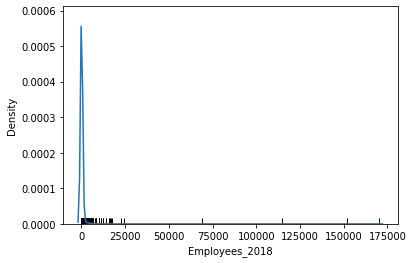

In [180]:
print('Employees example plot')
fig, ax = plt.subplots()
sb.distplot(df['Employees_2018'], hist = False, rug = True, rug_kws={'color': 'black'}, ax=ax)

We can think that a logarithmic transformation would be useful to obtain normal distributions, and indeed they are obtained. However, we cannot forget that revenues can have negative values, and even the number of employees is sometimes zero, so we cannot perform this transformation.

# Prepare Data

This problem can be faced in different ways. In this case, we have decided to take it as a supervised learning problem, in which we will use the revenues and employees data from the last 3 years available to predict the next year's revenues. We will train the model to predict 2019 revenues and use those parameters to predict 2020 revenues, taking into account that the data will be shifted by one year. This is probably not the optimal solution, but we believe that it might give some acceptable results.

To train the model we will use only rows that have revenue values in 2019 in order to not introduce some bias when we impute 2019 data. This is a little more than 10000 rows, so it seems a reasonable sample.

In [49]:
# Train with data we can test in 2019
complete_df = df.dropna(subset=['Revenue_2019'])
train_df_2019 = complete_df.drop(['Revenue_2015','Employees_2020'], axis=1)
# Split in Training and Validation
X = train_df_2019.drop(['Revenue_2019'], axis=1)
y = train_df_2019['Revenue_2019']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

We split the data into train and validation at 70-30.

In [50]:
X_train

,Revenue_2016,Revenue_2017,Revenue_2018,Employees_2017,Employees_2018,Employees_2019
14710,32523862.0,28348980.0,38320539.0,NaN,NaN,16.0
10911,NaN,50000.0,16000.0,NaN,NaN,NaN
5269,481865.0,594584.0,605859.0,NaN,NaN,9.0
2967,16912814.0,14486911.0,15408996.0,42.0,46.0,47.0
6109,291893.0,246113.0,151684.0,NaN,NaN,NaN
...,...,...,...,...,...,...
15948,55028.0,285693.0,572158.0,NaN,NaN,NaN
6720,59252.0,52012.0,91566.0,NaN,NaN,11.0
4681,137975.0,136430.0,222236.0,NaN,31.0,30.0
16740,8914.0,86429.0,223014.0,NaN,NaN,13.0


In [51]:
print("Validation Mean:", '%.3E' % Decimal(np.mean(y_val)))
print("Validation Median:",'%.3E' % Decimal(np.median(y_val)))

Validation Mean: 3.914E+07
Validation Median: 1.503E+06


# Naive Test (t1)

We first try a basic prediction to see if our model is working.
We use 2018 revenue as prediction for 2019 revenue.
As there are only 10 % missing values in the revenue_2018 column, we can assume that the type of imputer will not have much influence on this first naive estimate. Therefore we use a simple KNNImputer with n_neighbors = 2.

In [54]:
print('Number of missing values per column in train data')
np.round(X_train.isnull().sum(axis = 0).sort_values(ascending = False)/len(X_train),2)

Number of missing values per column in train data


Employees_2017    0.86
Employees_2018    0.63
Revenue_2016      0.28
Employees_2019    0.24
Revenue_2017      0.18
Revenue_2018      0.10
dtype: float64

In [57]:
# KNN Imputer
imputer = KNNImputer(n_neighbors=2)
X_train_t1 = imputer.fit(X_train)
X_val_t1 = imputer.transform(X_val)
# Get original indices
df_val_t1 = pd.DataFrame(X_val_t1, index=X_val.index, columns=X_val.columns)
# Prediction
y_val_pred_t1 = df_val_t1['Revenue_2018']

In [58]:
print("MAE =", '%.3E' % Decimal(mean_absolute_error(y_val, y_val_pred_t1)))
print("RMSE =", '%.3E' % Decimal(mean_squared_error(y_val, y_val_pred_t1, squared = True)))

MAE = 2.422E+07
RMSE = 1.062E+17


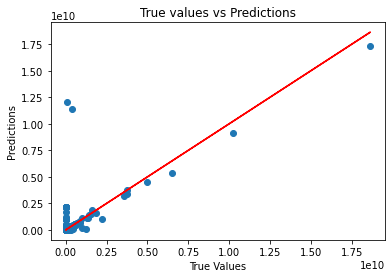

In [79]:
plt.scatter(y_val, y_val_pred_t1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True values vs Predictions')
plt.plot(y_val, y_val, color = 'red', label = 'y=x')
plt.show()

We can see that our naive estimation works quite well on much of the data, but has large errors. This can also be seen in the large difference between the MAE and the RMSE, which penalises larger errors more heavily.

# Prediction using Random Forest (t2)

Here we set up a pipeline with different steps. Then we create a parameter grid with a few values that we are going to train with a GridSearch and a cross validation with KFold = 3. 
We introduce the option to scale the data, as this might help in some cases to impute missing values. We also give two different options for imputation. Finally we give 3 different options in the min_samples_leaf and min_samples_split parameters of the Random Forest. We could add many more options, but we want to use the GridSearch and making it more complicated would add a lot of computation time. To train the model we use neg_mean_absolute_error, as that is the value we want to minimise in this case.



In [ ]:
#Pipeline

#Steps of the pipeline
steps = [('scaler', MinMaxScaler()),
         ('imputation', KNNImputer(n_neighbors=2)),
         ('regressor', RandomForestRegressor())]

#Create the pipeline
pipeline = Pipeline(steps)

# random.seed = 0 for reproducibility
np.random.seed(0)

#Specify the hyperparameter space
param_grid = {'scaler': [MinMaxScaler(), None],
              'imputation': [ KNNImputer(), IterativeImputer(random_state=0)],
              'regressor__max_depth':[30, 60, None],
              'regressor__min_samples_leaf': [1, 2, 4],
              'regressor__min_samples_split':[2, 5, 10],
              'regressor': [RandomForestRegressor()]}


# Create the Grid SearchCV object
pipeline_model = GridSearchCV(pipeline,
                              param_grid = param_grid,
                              scoring = 'neg_mean_absolute_error',
                              cv=3)

# Fit to the training set
gd_cv = pipeline_model.fit(X=X_train, y = y_train)

# Predict
y_val_pred_t2 = pipeline_model.predict(X_val)

In [182]:
print("Best parameters :", pipeline_model.best_params_)

Best parameters : {'imputation': IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0), 'regressor': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), 'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_

We can see that the best parameters are without the scaler, with the IterativeImputer and with the default parameters of the RandomForestRegressor.

In [99]:
print("MAE =", '%.3E' % Decimal(mean_absolute_error(y_val, y_val_pred_t2)))
print("RMSE =", '%.3E' % Decimal(mean_squared_error(y_val, y_val_pred_t2, squared = True)))

MAE = 7.784E+06
RMSE = 5.400E+15


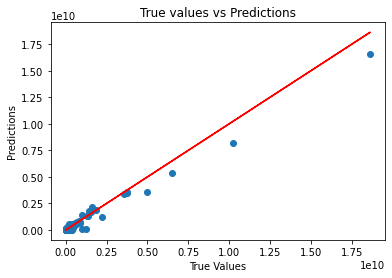

In [181]:
plt.title('True values vs Predictions')
plt.scatter(y_val, y_val_pred_t2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot(y_val, y_val, color = 'red', label = 'y=x')
plt.show()

In [101]:
results_RF = pd.DataFrame(gd_cv.cv_results_['params'])
results_RF['test_score'] = gd_cv.cv_results_['mean_test_score']

Regarding the results, we can see from the graph that the large errors made by our naive estimator have been fixed. This can be seen in the two orders of magnitude reduction in the RMSE. However, in terms of MAE the reduction has not been as large as could be expected at first.

# Final Prediction

Finally, and despite the slight improvements in the results, we cannot forget that the parameters obtained for 2019 are what will be used in the 2020 forecast. The performance of this one-year shift should be tested beforehand, if possible, with data from previous years.

In [108]:
final_df = raw_df.drop(['NAME', 'Revenue_2015', 'Revenue_2016', 'Employees_2017','Revenue_2020(To predict)'], axis=1)

In [109]:
final_df

,Revenue_2017,Revenue_2018,Revenue_2019,Employees_2018,Employees_2019,Employees_2020
0,2.457376e+10,2.260886e+10,2.657454e+10,805.0,790.0,785.0
1,3.420430e+09,3.265963e+09,3.465058e+09,2394.0,2494.0,2548.0
2,3.196900e+09,3.193700e+09,3.166000e+09,6506.0,7750.0,NaN
3,1.982028e+09,2.007387e+09,2.009031e+09,1925.0,1995.0,2050.0
4,1.245810e+09,1.317865e+09,1.779402e+09,5159.0,5599.0,5483.0
...,...,...,...,...,...,...
17419,NaN,NaN,NaN,NaN,100.0,99.0
17420,NaN,NaN,NaN,171.0,175.0,165.0
17421,2.830900e+04,1.306000e+03,NaN,NaN,NaN,12.0
17422,1.429000e+03,NaN,NaN,NaN,NaN,7.0


In [110]:
final_predict = pipeline_model.predict(final_df)

In [122]:
raw_df['Revenue_2020(To predict)'] = final_predict

In [123]:
raw_df

,NAME,Revenue_2015,Revenue_2016,Revenue_2017,Revenue_2018,Revenue_2019,Employees_2017,Employees_2018,Employees_2019,Employees_2020,Revenue_2020(To predict)
0,LAKI,1.903978e+10,2.467163e+10,2.457376e+10,2.260886e+10,2.657454e+10,NaN,805.0,790.0,785.0,1.975155e+10
1,YETS,3.687564e+09,3.663588e+09,3.420430e+09,3.265963e+09,3.465058e+09,NaN,2394.0,2494.0,2548.0,3.473084e+09
2,PNMD,3.139300e+09,3.214000e+09,3.196900e+09,3.193700e+09,3.166000e+09,6411.0,6506.0,7750.0,NaN,3.354596e+09
3,VKNF,1.994112e+09,2.023348e+09,1.982028e+09,2.007387e+09,2.009031e+09,NaN,1925.0,1995.0,2050.0,2.083830e+09
4,HHVD,7.612489e+08,1.121284e+09,1.245810e+09,1.317865e+09,1.779402e+09,NaN,5159.0,5599.0,5483.0,1.785612e+09
...,...,...,...,...,...,...,...,...,...,...,...
17419,ECYY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,99.0,2.191836e+07
17420,GCGH,NaN,NaN,NaN,NaN,NaN,NaN,171.0,175.0,165.0,2.279616e+07
17421,HCRP,7.793100e+04,5.968600e+04,2.830900e+04,1.306000e+03,NaN,NaN,NaN,NaN,12.0,7.864925e+04
17422,JXDE,3.068900e+04,6.182000e+03,1.429000e+03,NaN,NaN,NaN,NaN,NaN,7.0,3.128281e+05


In [124]:
raw_df.to_csv('dealroom_prediction')